In [1]:
import fastbook
fastbook.setup_book()

In [2]:
from fastai.vision.all import *
from fastbook import *

## Dataset paths

In [3]:
path_dataset = Path('/home/florian/projects/toy-jester')
path_videos = Path('/home/florian/projects/toy-jester/20bn-jester-v1')

In [117]:
path_dataset.ls()

(#7) [Path('/home/florian/projects/toy-jester/jester-v1-test.csv'),Path('/home/florian/projects/toy-jester/20bn-jester-v1'),Path('/home/florian/projects/toy-jester/jester-v1-labels.csv'),Path('/home/florian/projects/toy-jester/jester-v1-validation.csv'),Path('/home/florian/projects/toy-jester/toyjester-v1-validation.csv'),Path('/home/florian/projects/toy-jester/jester-v1-train.csv'),Path('/home/florian/projects/toy-jester/toyjester-v1-train.csv')]

## DataBlock setup

In [79]:
def get_x(item):
    # Each video is represented by one frame from the first half of the video
    frames = list((path_videos / str(item['video_id'])).glob('*.jpg'))
    return frames[len(frames)//3]

def get_y(item):
    return item['label']

In [113]:
import random
def splitter(df):
    train = df.index[~df.valid].tolist()
    valid = df.index[df.valid].tolist()
#     train.shuffle()
#     valid.shuffle()
#     print(train[:10])
    return train, valid

datablock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    splitter=RandomSplitter(seed=42),  # splitter
    get_y=get_y,
    get_x=get_x,
    item_tfms=Resize(128),
    batch_tfms=aug_transforms(size=112, max_warp=.05)
)

## Load data annotations

In [114]:
df_train = pd.read_csv(path_dataset/'toyjester-v1-train.csv', delimiter=';')
df_val = pd.read_csv(path_dataset/'toyjester-v1-validation.csv', delimiter=';')
df = pd.concat([
    df_train.assign(valid=0),
    df_val.assign(valid=1)
], axis=0)
df

,video_id,label,valid
0,139210,Rolling Hand Forward,0
1,70268,Pulling Two Fingers In,0
2,99754,Stop Sign,0
3,114650,Pulling Two Fingers In,0
4,92668,Turning Hand Clockwise,0
...,...,...,...
1474,137503,Doing other things,1
1475,132785,Rolling Hand Forward,1
1476,84798,Swiping Down,1
1477,140628,Zooming In With Full Hand,1


## Inspect some samples

In [115]:
dls = datablock.dataloaders(df)

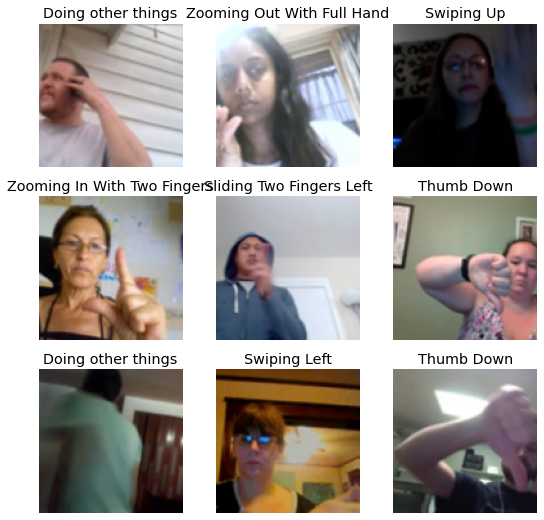

In [116]:
dls.show_batch(nrows=3, ncols=3)

## Create model ("leaner")

In [118]:
learn = cnn_learner(dls, resnet18, metrics=accuracy)

## Pick learning rate

SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=2.75422871709452e-06)

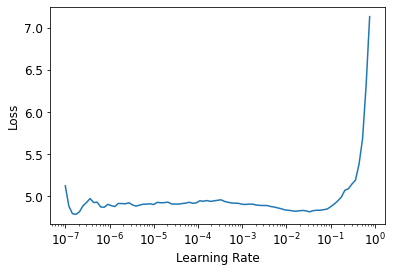

In [119]:
learn.lr_find()

## Training

In [59]:
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy,time
0,4.661421,3.711320,0.050190,00:09
1,4.182739,3.570953,0.052720,00:09
2,3.750590,3.443016,0.073809,00:09
3,3.505307,3.364125,0.070434,00:09


epoch,train_loss,valid_loss,accuracy,time
0,3.300199,3.258497,0.099114,00:11
1,3.144304,3.070079,0.134121,00:11
2,2.970121,3.059577,0.137916,00:11


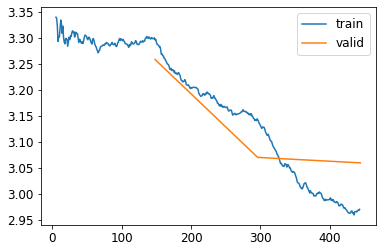

In [64]:
learn.recorder.plot_loss()

In [120]:
learn.fine_tune(10, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy,time
0,4.483058,3.402138,0.091114,00:11
1,3.812709,3.200352,0.121860,00:11
2,3.373248,3.024033,0.152981,00:11
3,3.119665,2.875006,0.188601,00:11


epoch,train_loss,valid_loss,accuracy,time
0,2.668945,2.478420,0.272216,00:13
1,2.370793,2.203931,0.334458,00:13
2,2.198906,1.986984,0.378703,00:13
3,1.972677,1.840256,0.417323,00:13
4,1.753991,1.827576,0.421822,00:13
5,1.618909,1.792480,0.439070,00:13
6,1.432522,1.796999,0.443570,00:13
7,1.269707,1.774552,0.460442,00:13
8,1.162268,1.757031,0.463067,00:13
9,1.127890,1.769550,0.455943,00:13


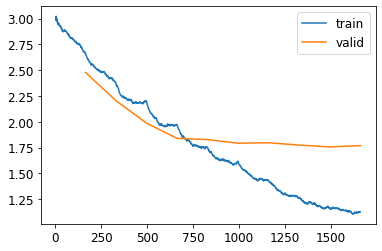

In [121]:
learn.recorder.plot_loss()

In [122]:
learn.fine_tune(10)

epoch,train_loss,valid_loss,accuracy,time
0,1.187039,1.866791,0.454068,00:12


epoch,train_loss,valid_loss,accuracy,time
0,1.132730,1.849983,0.459693,00:13
1,1.158324,1.913490,0.445069,00:13
2,1.183890,1.993030,0.439445,00:13
3,1.129158,1.977906,0.436820,00:13
4,1.058614,2.061309,0.419198,00:13
5,0.945019,2.023230,0.439820,00:13
6,0.851226,2.082884,0.437945,00:12
7,0.758585,2.136437,0.431946,00:12
8,0.681203,2.121163,0.437570,00:12
9,0.659131,2.131392,0.436445,00:13


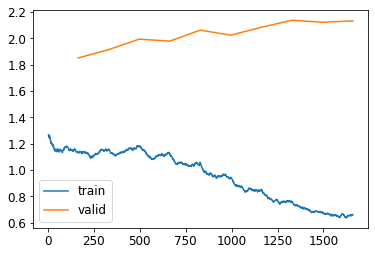

In [123]:
learn.recorder.plot_loss()

## Inspect trained model

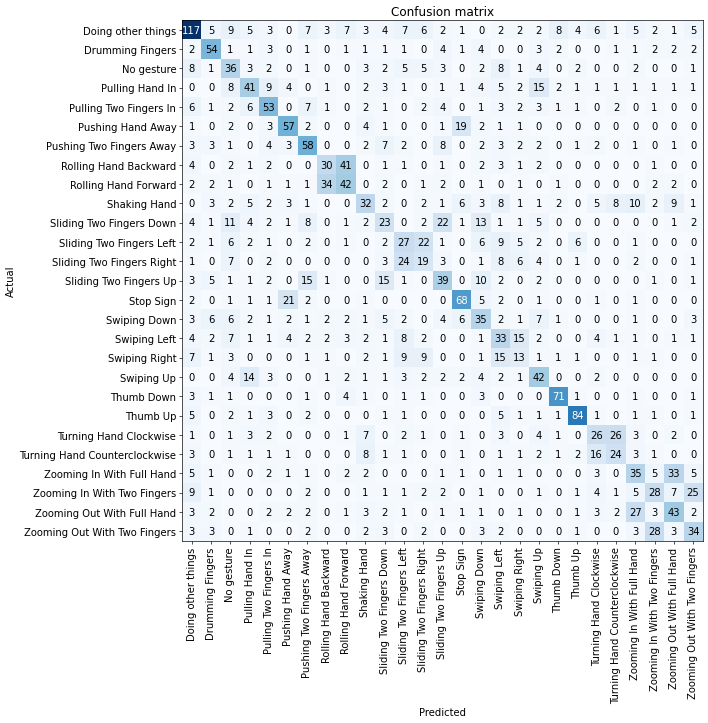

In [125]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)